# Agricultural Land Classification using CNN (PyTorch Version)

## Imports

In [6]:
import os
import random
from PIL import Image

import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [7]:
dataset_dir = "./images_dataSAT"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [8]:
dataset = datasets.ImageFolder(dataset_dir)

## Few samples of the satelite images

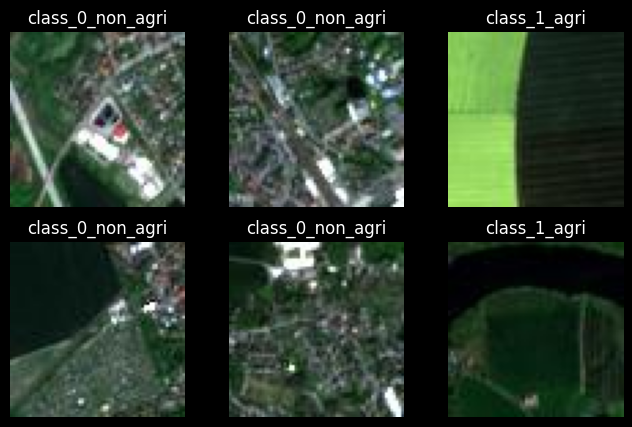

In [9]:
n_samples = 6

fig, axes = plt.subplots(nrows=2, ncols=n_samples//2, figsize=(8, 5))

for ax, (img, label) in zip(axes.flatten(), random.choices(dataset, k=n_samples)):
    ax.imshow(img)
    ax.set_title(dataset.classes[label])
    ax.axis("off")

In [26]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img.to(device), torch.tensor(label).to(device)

## Preprocession and augmentation pipeline

In [27]:
img_size = 64

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

## Train/Val Split 80:20

In [28]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_subset, val_subset = random_split(dataset, [train_size, val_size])

train_dataset = MyDataset(train_subset, transform=train_transform)
val_dataset = MyDataset(val_subset, transform=val_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 4800
Validation samples: 1200


In [29]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## CNN Architecture

In [30]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(16),

    nn.Conv2d(16, 32, kernel_size=5, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 16, kernel_size=5, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(16),

    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.BatchNorm1d(8),
    nn.Linear(8, len(dataset.classes)),
).to(device)

## Training loop

In [31]:
epochs = 3
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/3, Train Loss: 0.3454, Train Acc: 0.9060, Val Loss: 0.4347, Val Acc: 0.8408
Epoch 2/3, Train Loss: 0.1610, Train Acc: 0.9877, Val Loss: 0.1094, Val Acc: 0.9925
Epoch 3/3, Train Loss: 0.1013, Train Acc: 0.9904, Val Loss: 0.0732, Val Acc: 0.9933


## Loss and accuracy plots

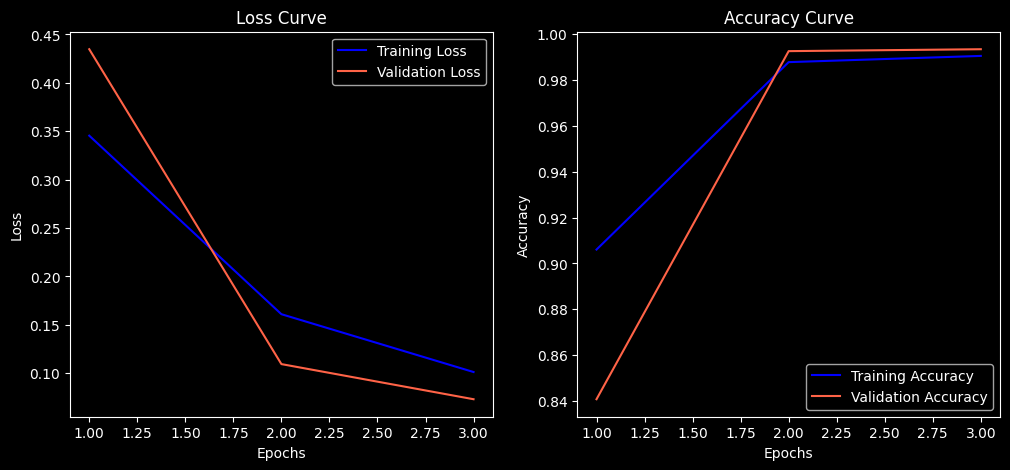

In [44]:
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color="blue")
plt.plot(epochs_range, val_losses, label='Validation Loss', color="tomato")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color="blue")
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color="tomato")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

## Classification report and Confusion matrix

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       599
           1       0.99      1.00      0.99       601

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



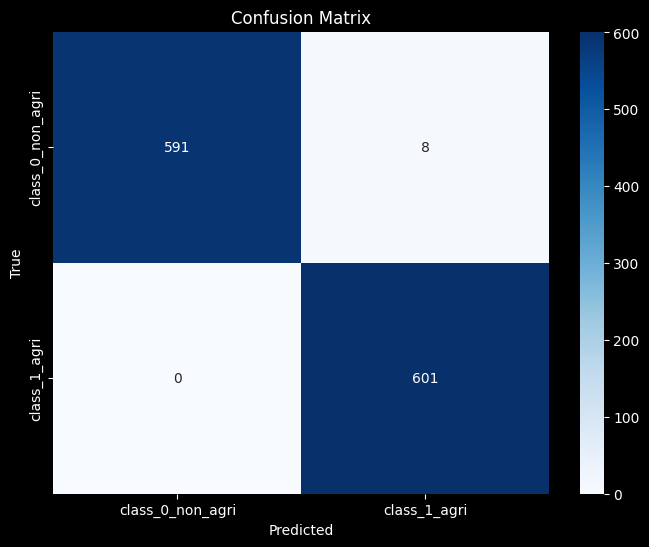

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


outputs = []
targets = []
with torch.no_grad():
    for images, labels in val_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        outputs.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

print(classification_report(targets, outputs))

cm = confusion_matrix(targets, outputs)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()